In [1]:
from sklearn.metrics import accuracy_score

In [3]:
from keras.utils.data_utils import get_file
from keras.layers.embeddings import Embedding
from keras import layers
from keras.layers import recurrent
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences

//anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
from __future__ import print_function
from functools import reduce
import re
import tarfile

import numpy as np

def tokenize(sent):
    token = []
    for x in re.split('(\W+)?', sent):
        if x.strip():
            token.append(x.strip())
    return token

def parse_stories(lines,only_supporting=False):
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            substory = None
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


def get_stories(file,only_supporting=False):
    data = parse_stories(file.readlines(),only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    
    temp_data = []
    for story, q, answer in data:
        temp_data.append((flatten(story), q, answer))
    return temp_data


def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    xs = []
    xqs = []
    ys = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        xs.append(x)
        xqs.append(xq)
        ys.append(y)
    return pad_sequences(xs, maxlen=story_maxlen), pad_sequences(xqs, maxlen=query_maxlen), np.array(ys)

# Download the dataset
try:
    path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise

task = 'tasks_1-20_v1-2/en/qa5_three-arg-relations_{}.txt'

with tarfile.open(path) as tar:
    train = get_stories(tar.extractfile(task.format('train')),only_supporting=True)
    test = get_stories(tar.extractfile(task.format('test')),only_supporting=True)

vocab = set()
for story, q, answer in train + test:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)


vocab_size = len(vocab) + 1
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
story_maxlen = max(map(len, (x for x, _, _ in train + test)))
query_maxlen = max(map(len, (x for _, x, _ in train + test)))

x, xq, y = vectorize_stories(train, word_idx, story_maxlen, query_maxlen)
tx, txq, ty = vectorize_stories(test, word_idx, story_maxlen, query_maxlen)

print('vocab = {}'.format(vocab))
print('x.shape = {}'.format(x.shape))
print('xq.shape = {}'.format(xq.shape))
print('y.shape = {}'.format(y.shape))
print('story_maxlen, query_maxlen = {}, {}'.format(story_maxlen, query_maxlen))

//anaconda/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


vocab = ['.', '?', 'Bill', 'Fred', 'Jeff', 'Mary', 'What', 'Who', 'apple', 'did', 'football', 'gave', 'give', 'handed', 'milk', 'passed', 'received', 'the', 'to']
x.shape = (1000, 7)
xq.shape = (1000, 8)
y.shape = (1000, 20)
story_maxlen, query_maxlen = 7, 8


In [20]:
RNN = recurrent.LSTM #recurrent.GRU
EMBED_HIDDEN_SIZE = 50
SENT_HIDDEN_SIZE = 100
QUERY_HIDDEN_SIZE = 100
BATCH_SIZE = 32
EPOCHS = 50

print('Build model...')

sentence = layers.Input(shape=(story_maxlen,), dtype='int32')
encoded_sentence = layers.Embedding(vocab_size, EMBED_HIDDEN_SIZE)(sentence)
encoded_sentence = layers.Dropout(0.3)(encoded_sentence)

question = layers.Input(shape=(query_maxlen,), dtype='int32')
encoded_question = layers.Embedding(vocab_size, EMBED_HIDDEN_SIZE)(question)
encoded_question = layers.Dropout(0.3)(encoded_question)
encoded_question = RNN(EMBED_HIDDEN_SIZE)(encoded_question)
encoded_question = layers.RepeatVector(story_maxlen)(encoded_question)

merged = layers.add([encoded_sentence, encoded_question])
merged = RNN(EMBED_HIDDEN_SIZE)(merged)
merged = layers.Dropout(0.3)(merged)
preds = layers.Dense(vocab_size, activation='softmax')(merged)

model = Model([sentence, question], preds)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print('Training')
model.fit([x, xq], y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.05)
loss, acc = model.evaluate([tx, txq], ty,
                           batch_size=BATCH_SIZE)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

Build model...
Training
Train on 950 samples, validate on 50 samples
Epoch 1/50
950/950 [==============================] - 2s 2ms/step - loss: 2.7193 - acc: 0.1368 - val_loss: 2.2086 - val_acc: 0.0800
Epoch 2/50
950/950 [==============================] - 1s 633us/step - loss: 2.0145 - acc: 0.1979 - val_loss: 1.6801 - val_acc: 0.2000
Epoch 3/50
950/950 [==============================] - 1s 600us/step - loss: 1.5525 - acc: 0.2863 - val_loss: 1.3282 - val_acc: 0.2000
Epoch 4/50
950/950 [==============================] - 1s 697us/step - loss: 1.4187 - acc: 0.2895 - val_loss: 1.3324 - val_acc: 0.2000
Epoch 5/50
950/950 [==============================] - 1s 596us/step - loss: 1.3664 - acc: 0.2905 - val_loss: 1.3019 - val_acc: 0.2000
Epoch 6/50
950/950 [==============================] - 1s 685us/step - loss: 1.3777 - acc: 0.2726 - val_loss: 1.2523 - val_acc: 0.4400
Epoch 7/50
950/950 [==============================] - 1s 685us/step - loss: 1.3498 - acc: 0.3074 - val_loss: 1.2568 - val_acc: 0.

In [21]:
#Test loss / test accuracy = 0.0004 / 1.0000 EPOCHS = 100 LSTM

In [22]:
#Test loss / test accuracy = 0.0100 / 1.0000   EPOCHS = 50 LSTM

In [23]:
#Test loss / test accuracy = 0.0014 / 1.0000 EPOCHS = 50 GRU

In [24]:
# Test loss / test accuracy = 0.0002 / 1.0000 EPOCHS = 100 GRU

In [25]:
idxToWord = {}
for key,value in word_idx.items():
    idxToWord[value] = key

In [26]:
predicted_values = model.predict([tx, txq])
predicted=[]
true=[]
for i in range(predicted_values.shape[0]):
    predicted.append(idxToWord[np.argmax(predicted_values[i])])
    true.append(idxToWord[np.argmax(ty[i])])

In [27]:
from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt

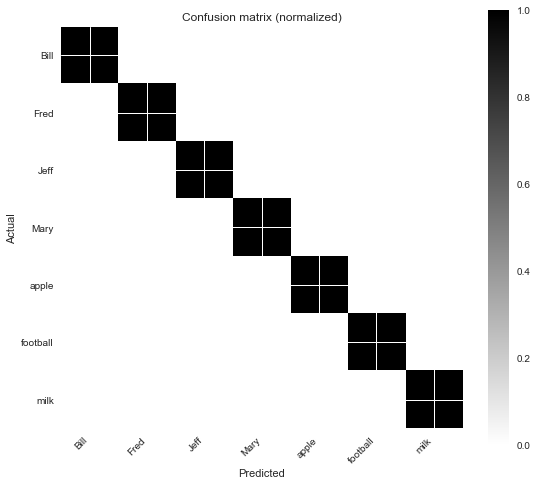

In [28]:
cm = ConfusionMatrix(predicted,true)
cm.plot(normalized=True)
plt.show()